In [249]:
import datetime as dt,numpy as np,pandas as pd
from pandas import DataFrame as DF
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from django_pandas.io import read_frame
from utils import *
import os
from os.path import join
import calendar
import statsmodels.formula.api as smf


pwd=os.getcwd()

In [399]:
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (11, 5)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

In [400]:
season=Season.objects.get(year=2011)
akwargs = dict(
    total_pay = F('coachpay__total'),
    record_desc = F('teamseasonrecord__desc'),
    wins = F('teamseasonrecord__win'),
    losses = F('teamseasonrecord__loss'),
    stat_cat = F('teamseasonstat__category'),
    stat_desc = F('teamseasonstat__desc'),
    stat_value = F('teamseasonstat__value'),
    stat_ovalue = F('teamseasonstat__ovalue'),
    coach_ln=F('coach__lastName'),
    conf=F('conference__name'),
    school=F('team__school__name'),
    capacity=F('stadium__capacity')
)

qs = TeamSeason.objects.filter(
    #season=season
).annotate(
    **akwargs
).values(
)

df=read_frame(qs)
df['stat']=df['stat_cat']+'-'+df['stat_desc']
df=df.drop(['stat_cat','stat_desc'],axis=1)
tdf=df.groupby('team_id')['gsr','fgr'].mean().rename(columns={'gsr':'gsr__avg','fgr':'fgr__avg'})
df=df.set_index('team_id').join(tdf).reset_index()

In [401]:
df=df[df['season_id']=='2019']
index=df.drop_duplicates(['school']).set_index('school').index
base=DF(index=index)
cfg_df = df[['school','conf','gsr__avg','fgr__avg','total_pay','capacity']].set_index('school')
cfg_df=base.join(cfg_df)
rdf = df[['school','record_desc','wins']].pivot_table(index='school',columns='record_desc')
rdf=rdf.xs(level=0,key='wins',axis=1)
rdf=base.join(rdf).dropna(axis=1).dropna()
stat_df=df[['school','stat','stat_value']].pivot_table(index='school',columns='stat')
stat_df=stat_df.xs(level=0,key='stat_value',axis=1)
stat_df=base.join(stat_df).dropna(axis=1).dropna()
odf = cfg_df.join(rdf).join(stat_df)
odf=odf.drop_duplicates()
odf.columns=odf.columns.str.replace(' ','_')
odf.columns=odf.columns.str.replace('/','_')
odf.columns=odf.columns.str.replace('-','_')
odf.columns=odf.columns.str.replace('.','')
odf.columns=odf.columns.str.replace('(','')
odf.columns=odf.columns.str.replace(')','')
odf.columns=odf.columns.str.replace('2','two')
odf.columns=odf.columns.str.replace('3rd','third')
odf.columns=odf.columns.str.replace('4th','fourth')
odf.columns=odf.columns.str.replace('%','percent')

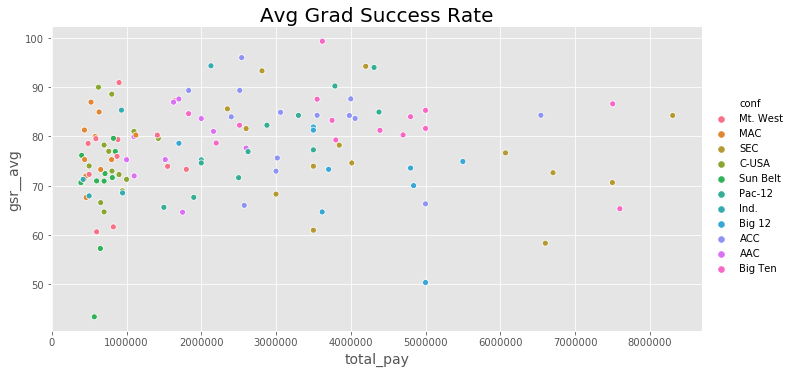

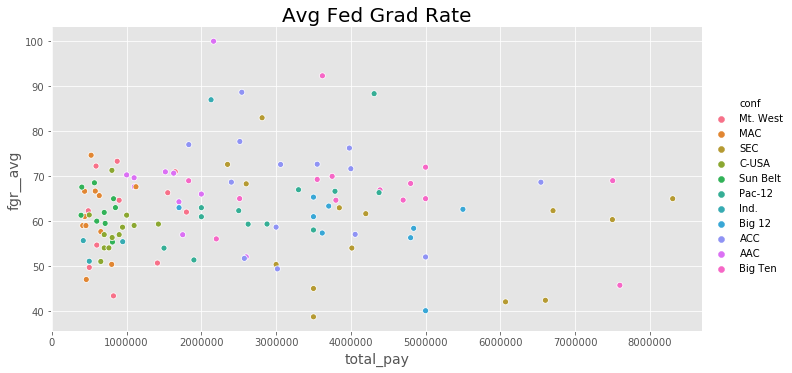

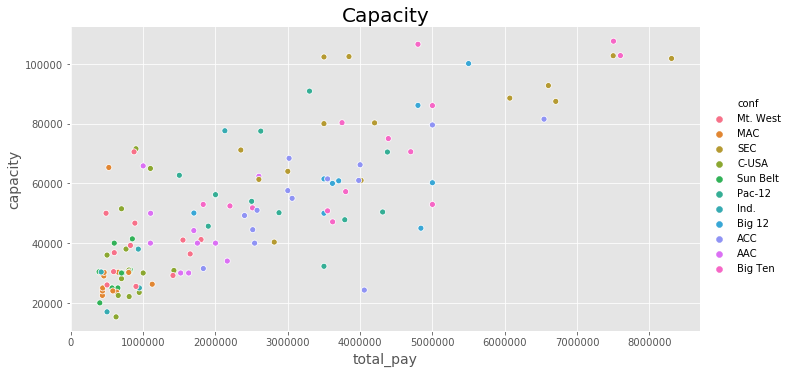

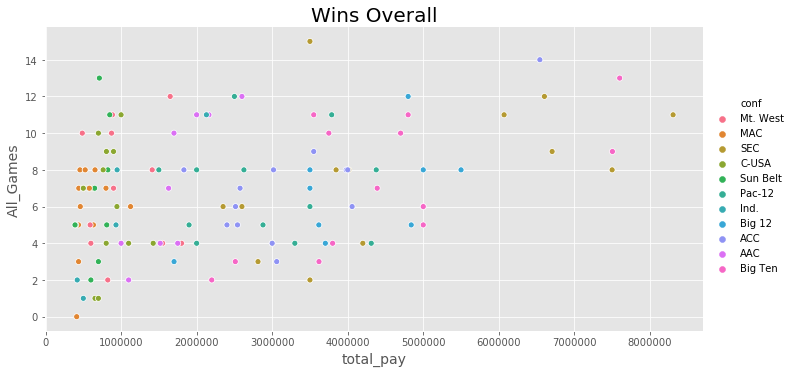

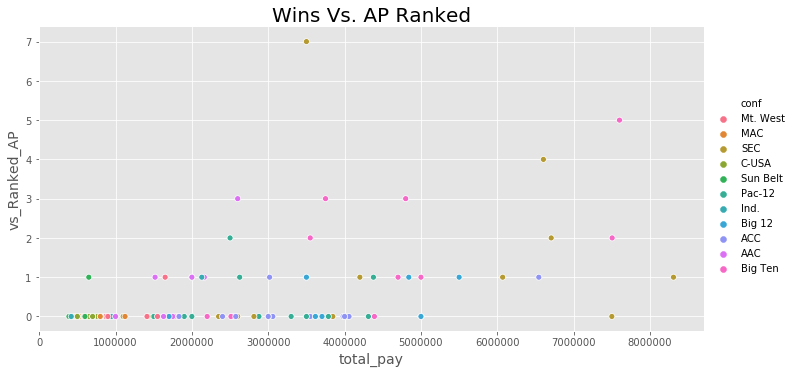

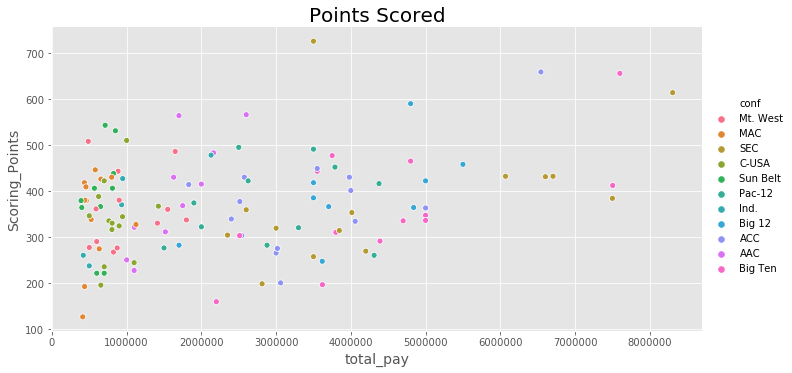

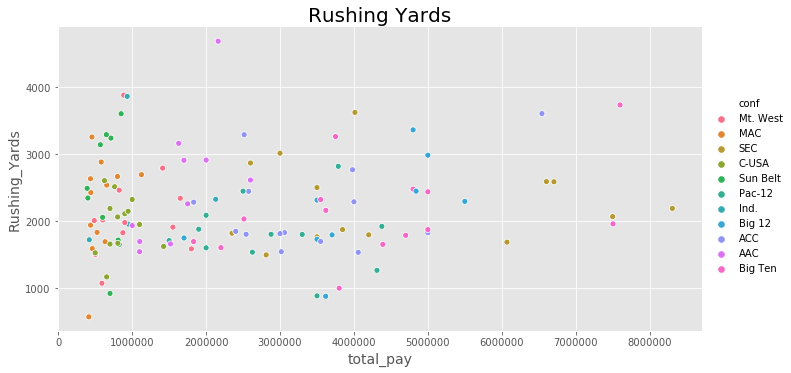

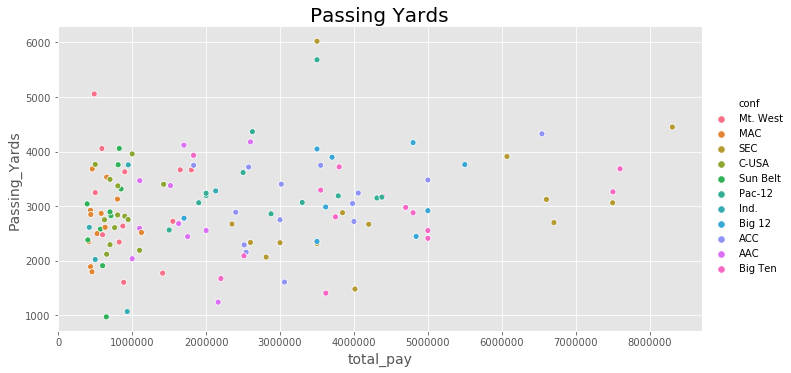

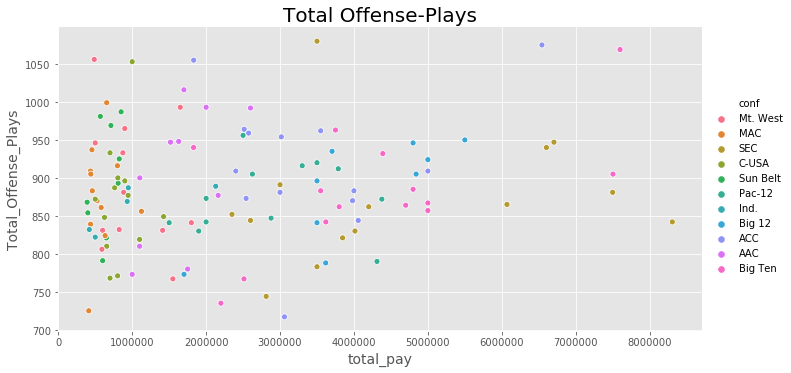

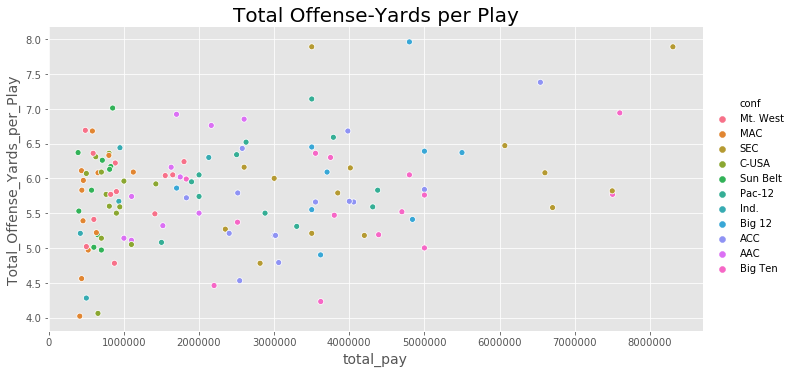

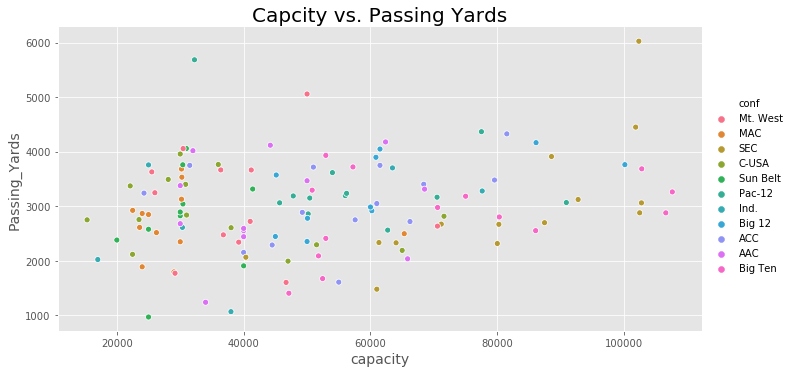

In [402]:
sns.relplot(data=odf,x='total_pay',y='gsr__avg',hue='conf',height=5,aspect=2)
plt.title("Avg Grad Success Rate")
plt.show()

sns.relplot(data=odf,x='total_pay',y='fgr__avg',hue='conf',height=5,aspect=2)
plt.title("Avg Fed Grad Rate")
plt.show()

sns.relplot(data=odf,x='total_pay',y='capacity',hue='conf',height=5,aspect=2)
plt.title("Capacity")
plt.show()

sns.relplot(data=odf,x='total_pay',y='All_Games',hue='conf',height=5,aspect=2)
plt.title("Wins Overall")
plt.show()

sns.relplot(data=odf,x='total_pay',y='vs_Ranked_AP',hue='conf',height=5,aspect=2)
plt.title("Wins Vs. AP Ranked")
plt.show()

sns.relplot(data=odf,x='total_pay',y='Scoring_Points',hue='conf',height=5,aspect=2)
plt.title("Points Scored")
plt.show()

sns.relplot(data=odf,x='total_pay',y='Rushing_Yards',hue='conf',height=5,aspect=2)
plt.title("Rushing Yards")
plt.show()

sns.relplot(data=odf,x='total_pay',y='Passing_Yards',hue='conf',height=5,aspect=2)
plt.title("Passing Yards")
plt.show()

sns.relplot(data=odf,x='total_pay',y='Total_Offense_Plays',hue='conf',height=5,aspect=2)
plt.title("Total Offense-Plays")
plt.show()


sns.relplot(data=odf,x='total_pay',y='Total_Offense_Yards_per_Play',hue='conf',height=5,aspect=2)
plt.title("Total Offense-Yards per Play")
plt.show()


sns.relplot(data=odf,x='capacity',y='Passing_Yards',hue='conf',height=5,aspect=2)
plt.title("Capcity vs. Passing Yards")
plt.show()

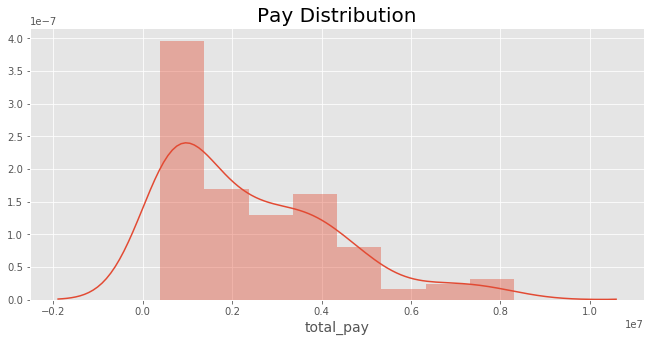

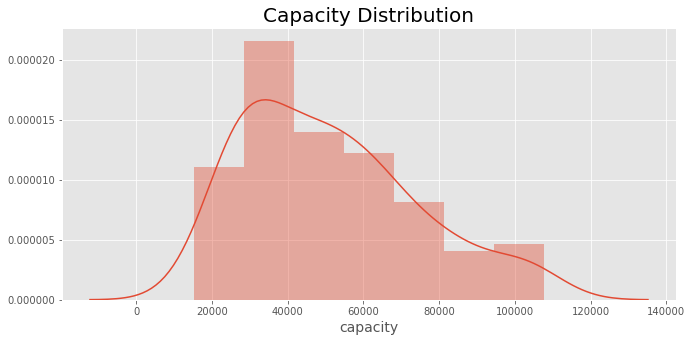

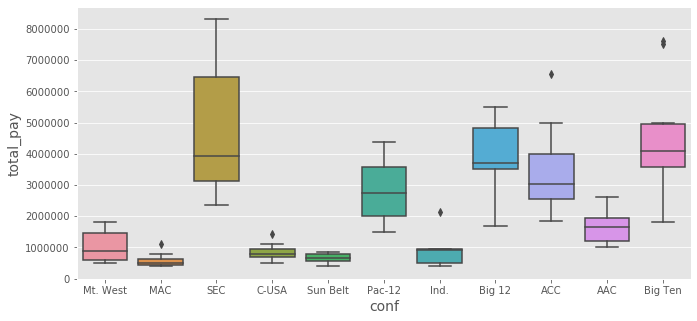

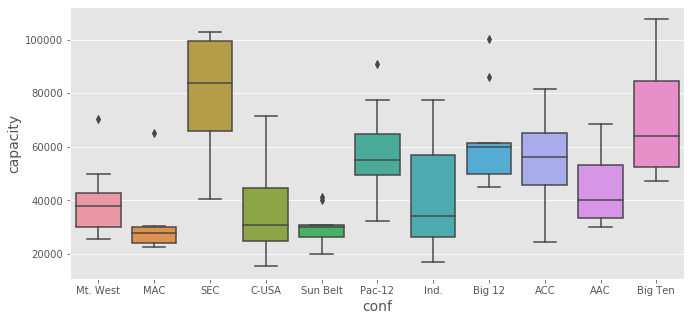

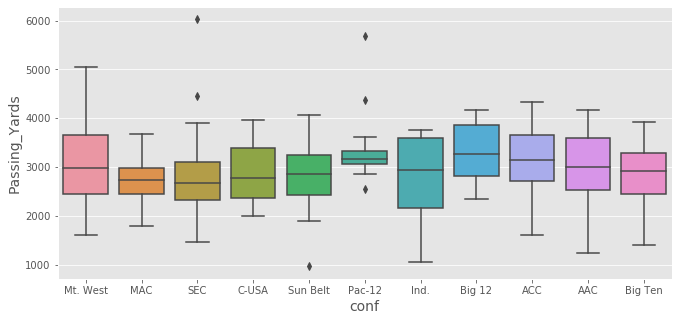

In [403]:
sns.distplot(odf.total_pay.dropna())
plt.title('Pay Distribution')
plt.show()

sns.distplot(odf.capacity.dropna())
plt.title('Capacity Distribution')
plt.show()

sns.boxplot(data=odf,x='conf',y='total_pay')
plt.show()

sns.boxplot(data=odf,x='conf',y='capacity')
plt.show()

sns.boxplot(data=odf,x='conf',y='Passing_Yards')
plt.show()

In [404]:
fits_df = DF(columns=['x','r2_adj','p'])

for col in odf.columns:
    if col=='total_pay':continue
    r = smf.ols(f'total_pay ~ {col}', data=odf).fit()

    a = dict(r2_adj=r.rsquared_adj,x=col,p=r.pvalues[1])
    fits_df=fits_df.append(a,ignore_index=True)


In [405]:
display(fits_df.sort_values('p').head())
display(fits_df[(fits_df['x']=='gsr__avg')|(fits_df['x']=='gsr__avg')])

,x,r2_adj,p
3,capacity,0.619758,8.208824e-28
16,vs_FBS_Power_5,0.573919,9.340230e-25
11,vs_BCS_AQ,0.528102,5.194631e-22
12,vs_BCS_non_AQ,0.232743,7.313622e-09
21,vs_Ranked_AP,0.217427,2.543457e-08


,x,r2_adj,p
1,gsr__avg,0.008929,0.148199


In [406]:
fits_df[(fits_df['x']=='conf')]

,x,r2_adj,p
0,conf,0.660766,0.000158


In [349]:
X_labels = fits_df.sort_values('p').head(5)['x'].values
X_labels

array(['capacity', 'vs_FBS_Power_5', 'vs_BCS_AQ', 'vs_BCS_non_AQ',
       'vs_Ranked_AP'], dtype=object)

In [ ]:
df

In [327]:
tdf = tdf[~pd.isna(tdf['total_pay'])]
ax=sns.distplot(tdf['total_pay']/10**6,norm_hist=False,kde=False)
ax.set_title('Total Coach Pay')
ax.set_xlabel('Total Pay [$M]')
ax.set_ylabel('Frequency')

KeyError: 'total_pay'